In [25]:
#Import necessary packages

import numpy as np
import pandas as pd
import math
import numpy.random as rand
import scipy
from scipy.stats import binom as binomial
from scipy.stats import beta as betafunction
from scipy.stats import norm
from scipy.stats import gamma
import matplotlib.pyplot as plt
from IPython.display import display
import sys
import pickle
import PTMCMCSampler
from PTMCMCSampler import PTMCMCSampler as ptmcmc
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True) #Want to be able to use tex in the plot labels


In [26]:
#Draw veff from prior:
def veffprop(x,iter,beta):
    q = x.copy()
    qxy = 0.
    
    q[6] = np.random.normal(0.75,0.01)
    qxy = scipy.stats.norm.pdf(q[6],0.75,0.1)

    if iter>40000:
        qxy = 1.
        q = x.copy()
    return q, qxy

class LikelihoodWrapper(object):   #Necessary because I want to use the iteration number to set proposals.
    """Wrapper for likelihood function.
        
        :param likelihood: Likelihood function that reads in parameter vector x and iteration
        """
            
    def __init__(self, likelihood):
        self.likelihood = likelihood
        self.iter = 0
    
    def __call__(self, x):
        ret = self.likelihood(x, self.iter)
        self.iter += 1
        return ret



    

In [27]:
#Real data, read in with Pandas. (Most of this data is not public and so not included in repository. Sorry.)
vobs_pandas = pd.read_csv('../Data/Xvax.csv')                #People who reported vaccination
vtrials_pandas = pd.read_csv('../Data/Nvax.csv')             #Number of people surveyed about vacc.
sobs_pandas = pd.read_csv('../Data/YseroNew.csv')            #positive serology tests
strials_pandas = pd.read_csv('../Data/NseroNew.csv')         #all serology tests
cases_pandas = pd.read_csv('../Data/reported_cases_lab.csv') #There are lab-confirmed and suspected cases

#Select the location you want to work with
#Full list: = ['KINSHASA','EQUATEUR','MANIEMA','ORIENTALE','BANDUNDU', 'BAS-CONGO', 'KASAI-OCCIDENTAL', 'KASAI-ORIENTAL',
#           'KATANGA', 'NORD-KIVU', 'SUD-KIVU' ]
loc_subset = ['KASAIOCC'] #We work with one province at a time in general
vobs = vobs_pandas.loc[:,loc_subset]
vtrial = vtrials_pandas.loc[:,loc_subset]
sobs = sobs_pandas.loc[:,loc_subset]
strial = strials_pandas.loc[:,loc_subset]
cases = cases_pandas.loc[:,loc_subset]

#Convert to numpy arrays
vo = vobs.values
vt = vtrial.values
so = sobs.values
st = strial.values
co = cases.values

vo = np.sum(vo,axis=-1)
vt = np.sum(vt,axis=-1)
so = np.sum(so,axis=-1)
st = np.sum(st,axis=-1)
co = np.sum(co,axis=-1)

vobs = np.copy(vo)
vtry = np.copy(vt)
sobs = np.copy(so)
stry = np.copy(st)
cobs = np.copy(co)

print np.shape(vo)

(60,)


In [28]:
#Read in and process data from simulation
'''
Data_pd = pd.read_csv("FakeData50.csv",header=None)
Data = Data_pd.as_matrix()
vo = Data[:,0].copy()
vt = Data[:,1].copy()
so = Data[:,2].copy()
st = Data[:,3].copy()
cobs = Data[:,4].copy()

vobs = vo.copy()
vtry = vt.copy()
sobs = so.copy()
stry = st.copy()
'''

'\nData_pd = pd.read_csv("FakeData50.csv",header=None)\nData = Data_pd.as_matrix()\nvo = Data[:,0].copy()\nvt = Data[:,1].copy()\nso = Data[:,2].copy()\nst = Data[:,3].copy()\ncobs = Data[:,4].copy()\n\nvobs = vo.copy()\nvtry = vt.copy()\nsobs = so.copy()\nstry = st.copy()\n'

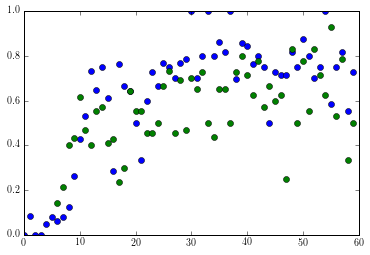

In [29]:
#Plot data to make sure it doesn't look crazy.

total_cases = np.sum(cobs[:])

plt.plot(vobs.astype(float)/vtry.astype(float),'bo')
plt.plot(sobs.astype(float)/stry.astype(float),'go')



In [30]:
#Now define the prior and likelihood:

def logltest(x,iter):  #Run with this likelihood to make sure you recover the prior. For testing new jump props.
    return 0.0

def logl(x,iter): 
    lnlike = 0.
    N = len(vobs) #Length of data
    
    #Parameters
    va = x[0]
    vb = x[1]
    vh = x[2]
    
    fa = x[3]
    fb = x[4]
    fh = x[5]
    
    ve = x[6]
    c = x[7]
    alpha = x[8]
    #c = 0.
    #alpha = 1.

    
    vprob = np.zeros(N)
    sprob = np.zeros(N)
    cprob = np.zeros(N)
    for i in range(0,N):
        a = float(i+1.)
        vprob[i] = 1. - np.exp(-vh*(1. - np.exp(-(a/vb)**va)))
        sprob[i] = 1. - np.exp(-vh*ve*(1. - np.exp(-(a/vb)**va)) - (alpha)*fh*(1. - np.exp(-(a/fb)**fa))-c*a)
        cprob[i] = (1.- np.exp(-(alpha)*fh*(fa/fb)*(a*12./fb)**(fa-1.)*np.exp(-(a*12./fb)**fa)-c))*\
                                       (np.exp(-ve*vh*(1.-np.exp(-(a*12./vb)**va))-fh*(alpha)*(1.-np.exp(-(a*12./fb)**fa))\
                                        -c*a*12.))
                                    
        if vprob[i] < 0.0:
            #print vprob
            return -np.inf
        if sprob[i] < 0.0:
            #print sprob
            return -np.inf
        
        lnlike += np.log(binomial.pmf(vobs[i],vtry[i],vprob[i]))
        if a>= 6:
            lnlike += np.log(binomial.pmf(sobs[i],stry[i],sprob[i]))
        #lnlike += 0.
   
    cprob /= sum(cprob[:]) 
    lnlike += scipy.stats.multinomial.logpmf(cobs[:],total_cases,cprob[:])
    return lnlike



def lnprior(x):
    logp = 0.
    
    valpha = x[0]
    vbeta = x[1]
    vheight = x[2]
    falpha = x[3]
    fbeta = x[4]
    fheight = x[5]
    veff = x[6]
    
    c = x[7]
    alpha = x[8]

    logp += np.log(gamma.pdf(valpha,a=2.,scale=5.))
    logp += np.log(gamma.pdf(vbeta,a=2.,scale=500.))
    logp += np.log(gamma.pdf(vheight,a=2.,scale=15.))
    
    logp += np.log(gamma.pdf(falpha,a=2.,scale=5.))
    logp += np.log(gamma.pdf(fbeta,a=1.6,scale=200.))
    logp += np.log(gamma.pdf(fheight,a=2.,scale=15.))
    
    #logp += np.log(scipy.stats.beta.pdf(veff,a=85.,b=15.)) #Strict
    logp += np.log(scipy.stats.beta.pdf(veff,a=16.,b=5.))  #Moderate
    #logp += np.log(scipy.stats.beta.pdf(veff,a=1.,b=1.))   #Flat prior
    
    if fbeta>400.:
        return -np.inf
    if c<0.0001 or c>100.:
        return -np.inf
    if alpha<0. or alpha>1.0:
        return -np.inf
    if veff<0. or veff>1.0:
        return -np.inf
    if vbeta>100.:
        return -np.inf
    
    return logp



In [31]:
#Now load in the samples and make a plot.
samples = []
i = 0
burnin = 1000
for line in open('chains/BFtest/c_only/KASAIOCC/chain_1.txt','r'):
    sample = line.split()
    if i> burnin:
        samples.append(sample)
    i += 1

samples = np.array(samples)
print np.shape(samples)

samples = samples.astype(float)

samples2 = []
i = 0
burnin = 500
for line in open('chains/BFtest/KASAIOCC/chain_1.txt','r'):
    sample = line.split()
    if i> burnin:
        samples2.append(sample)
    i += 1

samples2 = np.array(samples2)
print np.shape(samples2)

samples2 = samples2.astype(float)




(489, 13)
(989, 13)


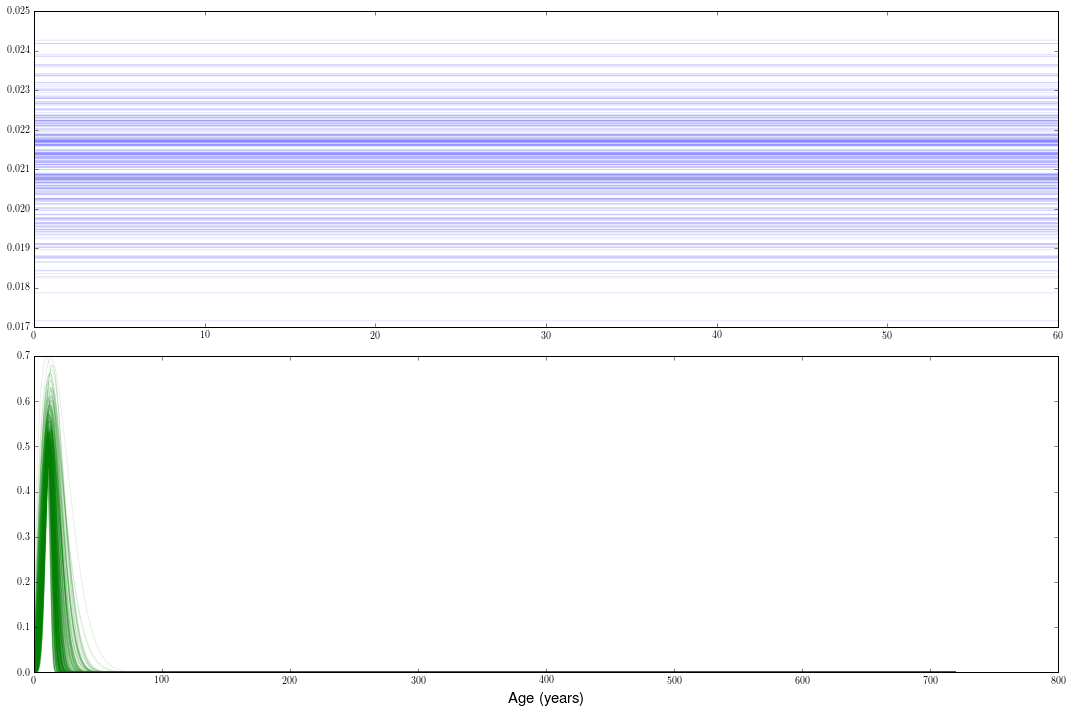

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
#ax0 = axes
ax0, ax1 = axes.flatten()
nspace = 2000
x = np.linspace(1,60*12,nspace)
foi = np.zeros(nspace)
vhaz = np.zeros(nspace)
vpeak = []
l = len(samples[:,0])
nplot = 300
for k in range(nplot):
    index = np.random.randint(l)

    va = samples[index,0] 
    vb = samples[index,1] 
    vh = samples[index,2]  
    fa = samples[index,3] 
    fb = samples[index,4] 
    fh = samples[index,5] 
    ve = samples[index,6]
    
    c = samples[index,7]
    alpha = samples[index,8]
    
    apeak = (vb**(va)*(va-1.))**(1./(va+1.))
    vpeak.append(apeak)
    alpha = 0.

    m = 0
    for i in x:
        a = float(i)
        foi[m] = alpha*fh*(a/fb)**(fa-1.)*np.exp(-(a/fb)**(fa))+c
        vhaz[m] = vh*(a/vb)**(va-1.)*np.exp(-(a/vb)**(va))
        m += 1
    ax0.plot(x/12.,foi,alpha=0.1,color='b')
    ax1.plot(x,vhaz,alpha=0.1,color='g')

plt.xlabel('Age (years)',fontsize=15)
#ax1.set_xlim(6,24)
#ax0.set_ylim(0,20)
fig.tight_layout()


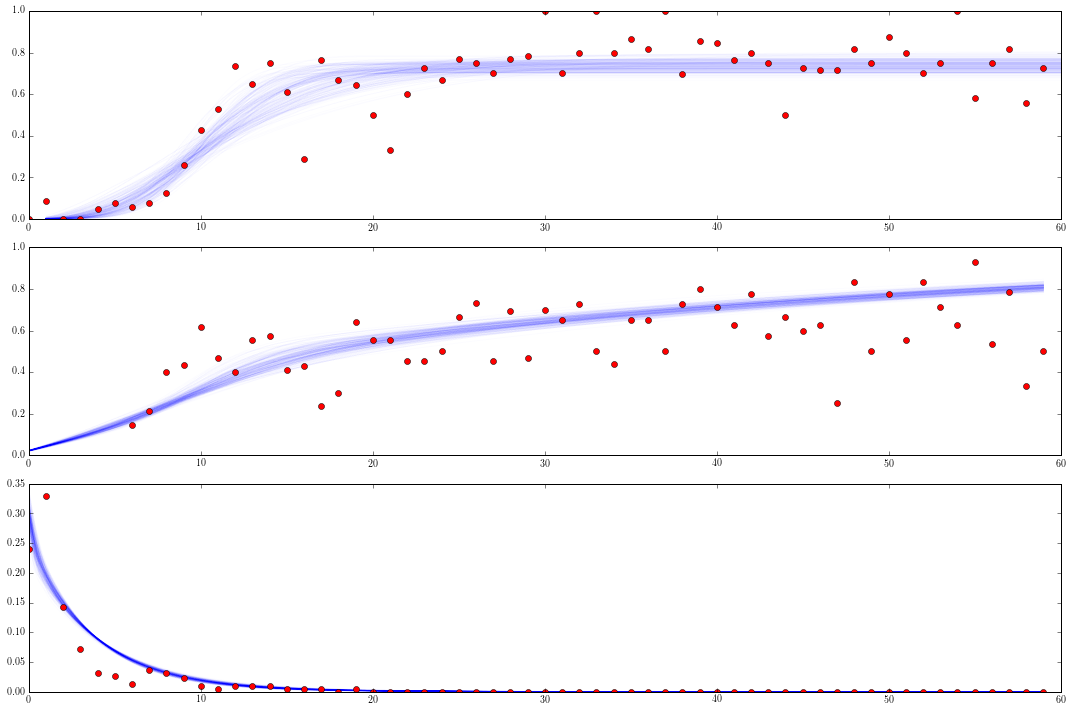

In [33]:
nspace = 500
x = np.linspace(1,60,nspace)

cplot = np.zeros(nspace)
vplot = np.zeros(nspace)
splot = np.zeros(nspace)
vplot2 = np.zeros(nspace)
splot2 = np.zeros(nspace)
cplot2 = np.zeros(nspace)
vmax = []
l = len(samples[:,0])
nplot = 300
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,10))
ax0, ax1, ax2 = axes.flatten()

for k in range(nplot):
    index = np.random.randint(l)
    
    va = samples[index,0]
    vb = samples[index,1]
    vh = samples[index,2]
    fa = samples[index,3]
    fb = samples[index,4]
    fh = samples[index,5]
    ve = samples[index,6]
    
    c = samples[index,7]
    alpha = samples[index,8]
    alpha = 0.
    
    va2 = samples2[index,0]
    vb2 = samples2[index,1]
    vh2 = samples2[index,2]
    fa2 = samples2[index,3]
    fb2 = samples2[index,4]
    fh2 = samples2[index,5]
    ve2 = samples2[index,6]
    
    j = 0
    for i in x:
        a = float(i)
        vplot[j] = 1. - np.exp(-vh*(1. - np.exp(-(a/vb)**va)))
        vplot2[j] = 1. - np.exp(-vh2*(1. - np.exp(-(a/vb2)**va2)))
        splot[j] = 1. - np.exp(-vh*ve*(1. - np.exp(-(a/vb)**va)) - (alpha)*fh*(1. - np.exp(-(a/fb)**fa))-c*a)
        splot2[j] = 1. - np.exp(-vh2*ve2*(1. - np.exp(-(a/vb2)**va2)) - fh2*(1. - np.exp(-(a/fb2)**fa2)))
        cplot[j] = (1.- np.exp(-(alpha)*fh*(fa/fb)*(a*12./fb)**(fa-1.)*np.exp(-(a*12./fb)**fa)-c))*\
                                       (np.exp(-ve*vh*(1.-np.exp(-(a*12./vb)**va))-fh*(alpha)*(1.-np.exp(-(a*12./fb)**fa))\
                                        -c*a*12.))
        cplot2[j] = (1.- np.exp(-fh2*(fa2/fb2)*(a*12./fb2)**(fa2-1.)*np.exp(-(a*12./fb2)**fa2)))*\
                                   (np.exp(-ve2*vh2*(1.-np.exp(-(a*12./vb2)**va2))-fh2*(1.-np.exp(-(a*12./fb2)**fa2))))
        j += 1
    vm = vplot[-1]*ve
    vmax.append(vm)
    ax0.plot(x,vplot,alpha=0.01,color='b')
    #ax0.plot(x,vplot2,alpha=0.01,color='g')
    ax1.plot(x-1,splot,alpha=0.01,color='b')
    #ax1.plot(x-1,splot2,alpha=0.01,color='g')
    ax2.plot(x-1,cplot/(sum(cplot)*(x[1]-x[0])),alpha=0.01,color='b')
    #ax2.plot(x-1,cplot2/(sum(cplot2)*(x[1]-x[0])),alpha=0.01,color='g')
        
ax0.plot(vobs.astype(float)/vtry.astype(float), 'ro')
ax1.plot(sobs.astype(float)/stry.astype(float),'ro')
ax2.plot(cobs.astype(float)/total_cases,'ro')

plt.xlim(0,60)
fig.tight_layout()
#plt.savefig('Equateur_fits_constandweibull.png')

(989, 13)


(0, 0.01)

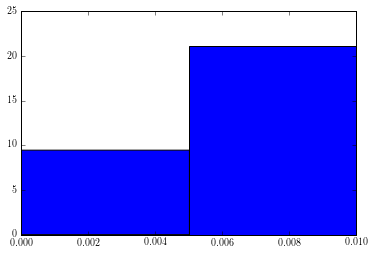

In [59]:
samples2 = []
i = 0
burnin = 500
for line in open('chains/BFtest/KASAIOCC/chain_1.txt','r'):
    sample = line.split()
    if i> burnin:
        samples2.append(sample)
    i += 1

samples2 = np.array(samples2)
print np.shape(samples2)

samples2 = samples2.astype(float)


edges = np.linspace(0.,1.,200)
a,b,c = plt.hist(samples2[:,8],bins=edges,normed=True)
plt.xlim(0,0.01)
#plt.ylim(0,2.0)
#plt.savefig('alphapost.png')

In [35]:
vpeak = np.array(vpeak)
vmax =  np.array(vmax)

In [36]:
print np.mean(vpeak)
print np.std(vpeak)
print np.mean(vmax)
print np.std(vmax)
print np.mean(samples[:,7])
print np.std(samples[:,7])

8.60613430138
1.03326477006
0.206359181668
0.0340152527327
0.0212592307514
0.00131706974829


In [37]:
toplot = pd.read_csv('vhaz_maxcov_foi.txt',sep=' ')

In [38]:
toplot

,province,vp,vps,vm,vms,c,cs,vem,vems
0,Bandundu,9.44,0.78,0.820,0.0160,0.0120,0.0010,0.330,0.032
1,Equateur,9.,0.53,0.690,0.0150,0.0190,0.0013,0.514,0.037
2,KasaiOcc,8.583,1.03,0.730,0.0250,0.0210,0.0013,0.210,0.031
3,Kinshasa,9.78,0.54,0.910,0.0016,0.0170,0.0013,0.476,0.049
4,Maniema,9.67,0.85,0.660,0.0250,0.0270,0.0030,0.565,0.039
5,Orientale,9.15,0.68,0.710,0.0170,0.0130,0.0010,0.597,0.032
6,Katanga,NAN,NAN,0.618,0.0500,0.0084,0.0014,NaN,NaN
7,BasCongo,NaN,NaN,0.424,0.0480,0.0086,0.0020,NaN,NaN


In [39]:
toplot.sort(['c'])

/Users/laurasampson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


,province,vp,vps,vm,vms,c,cs,vem,vems
6,Katanga,NAN,NAN,0.618,0.0500,0.0084,0.0014,NaN,NaN
7,BasCongo,NaN,NaN,0.424,0.0480,0.0086,0.0020,NaN,NaN
0,Bandundu,9.44,0.78,0.820,0.0160,0.0120,0.0010,0.330,0.032
5,Orientale,9.15,0.68,0.710,0.0170,0.0130,0.0010,0.597,0.032
3,Kinshasa,9.78,0.54,0.910,0.0016,0.0170,0.0013,0.476,0.049
1,Equateur,9.,0.53,0.690,0.0150,0.0190,0.0013,0.514,0.037
2,KasaiOcc,8.583,1.03,0.730,0.0250,0.0210,0.0013,0.210,0.031
4,Maniema,9.67,0.85,0.660,0.0250,0.0270,0.0030,0.565,0.039


In [40]:
peaks = toplot.vp.values
psig = toplot.vps.values
maxv = toplot.vem.values
mvsig = toplot.vems.values
cvals = toplot.c.values
csig = toplot.cs.values

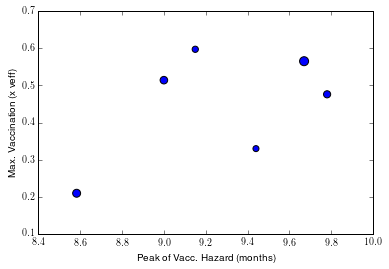

In [41]:
plt.scatter(peaks,maxv,s=cvals*3000)
plt.xlabel('Peak of Vacc. Hazard (months)')
plt.ylabel('Max. Vaccination (x veff)')
plt.savefig('trialfigure_c+W.png')
#plt.errorbar(peaks,maxv,xerr=psig,yerr=mvsig,linestyle='None')

In [42]:
#Plot of all three fits for each province
prov = 'KASAIOCC'

loc_subset = [prov] #We work with one province at a time in general
vobs = vobs_pandas.loc[:,loc_subset]
vtrial = vtrials_pandas.loc[:,loc_subset]
sobs = sobs_pandas.loc[:,loc_subset]
strial = strials_pandas.loc[:,loc_subset]
cases = cases_pandas.loc[:,loc_subset]

#Convert to numpy arrays
vo = vobs.values
vt = vtrial.values
so = sobs.values
st = strial.values
co = cases.values

vo = np.sum(vo,axis=-1)
vt = np.sum(vt,axis=-1)
so = np.sum(so,axis=-1)
st = np.sum(st,axis=-1)
co = np.sum(co,axis=-1)

vobs = np.copy(vo)
vtry = np.copy(vt)
sobs = np.copy(so)
stry = np.copy(st)
cobs = np.copy(co)

samples = []
i = 0
burnin = 500
for line in open('chains/BFtest/c_only/'+prov+'/chain_1.txt','r'):
    sample = line.split()
    if i> burnin:
        samples.append(sample)
    i += 1

samples = np.array(samples)
print np.shape(samples)

samples = samples.astype(float)
conly = samples.copy()

samples = []
i = 0
burnin = 500
for line in open('chains/BFtest/'+prov+'/chain_1.txt','r'):
    sample = line.split()
    if i> burnin:
        samples.append(sample)
    i += 1

samples = np.array(samples)
print np.shape(samples)
samples = samples.astype(float)
wplusc = samples.copy()

samples = []
i = 0
burnin = 11500
for line in open('chains/DRCLab/sero/'+prov+'/chain_1.txt'):
    sample = line.split()
    if i> burnin:
        samples.append(sample)
    i += 1

samples = np.array(samples)
print np.shape(samples)
samples = samples.astype(float)
wonly = samples.copy()

(989, 13)
(989, 13)
(949, 12)


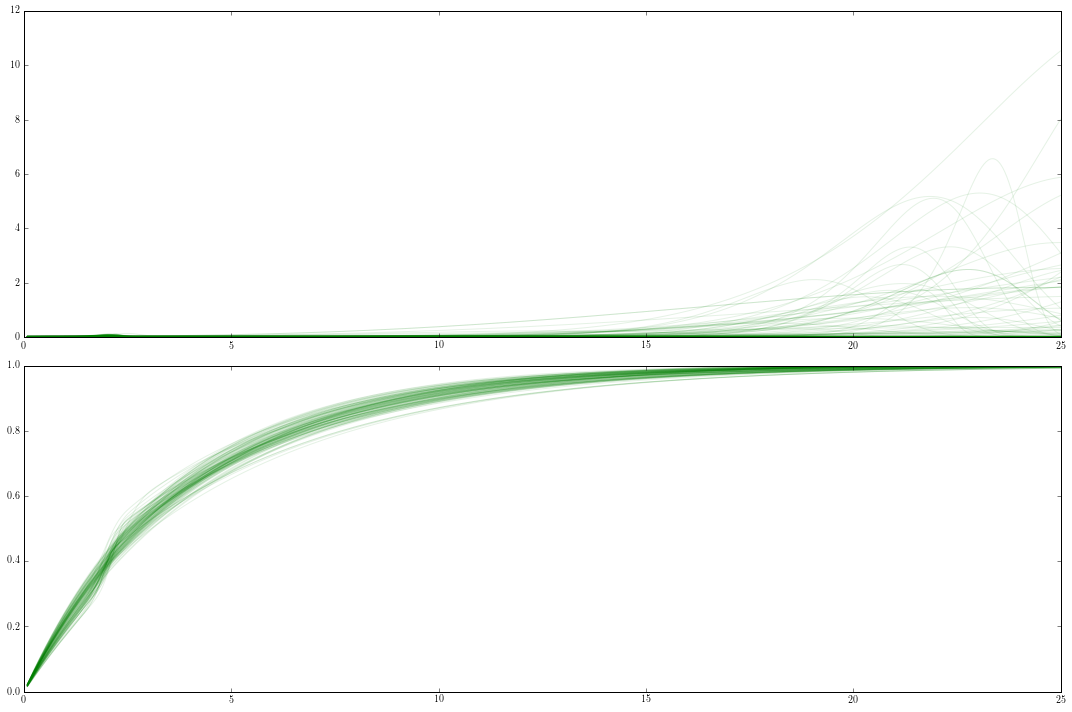

In [43]:
nspace = 1000
x = np.linspace(1,25*12,nspace)
foi = np.zeros(nspace)
splot = np.zeros(nspace)
l = len(samples[:,0])-1
nplot = 100
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
ax0, ax1 = axes.flatten()

for k in range(nplot):
    index = np.random.randint(l)
    
    va = conly[index,0]
    vb = conly[index,1]
    vh = conly[index,2]
    fa = conly[index,3]
    fb = conly[index,4]
    fh = conly[index,5]
    ve = conly[index,6]
    
    c = conly[index,7]
    alpha = 0.
    
    j = 0
    for i in x:
        a = float(i)
        foi[j] = c
        splot[j] = 1. - np.exp(-alpha*fh*(1.-np.exp(-(a/fb)**fa))-c*a)
        j += 1

    #ax0.plot(x/12,foi,alpha=0.1,color='b')
    #ax1.plot(x/12,splot,alpha=0.1,color='b')
    
    va = wplusc[index,0]
    vb = wplusc[index,1]
    vh = wplusc[index,2]
    fa = wplusc[index,3]
    fb = wplusc[index,4]
    fh = wplusc[index,5]
    ve = wplusc[index,6]
    
    c = wplusc[index,7]
    alpha = wplusc[index,8]
    
    j = 0
    for i in x:
        a = float(i)
        foi[j] = alpha*fh*(a/fb)**(fa-1.)*np.exp(-(a/fb)**(fa))+c
        splot[j] = 1. - np.exp(-alpha*fh*(1.-np.exp(-(a/fb)**fa))-c*a)
        j += 1

    ax0.plot(x/12,foi,alpha=0.1,color='g')
    ax1.plot(x/12,splot,alpha=0.1,color='g')
    
    va = wonly[index,0]
    vb = wonly[index,1]
    vh = wonly[index,2]
    fa = wonly[index,3]
    fb = wonly[index,4]
    fh = wonly[index,5]
    ve = wonly[index,6]
    
    c = 0.
    alpha = 1.
    
    j = 0
    for i in x:
        a = float(i)
        foi[j] = alpha*fh*(a/fb)**(fa-1.)*np.exp(-(a/fb)**(fa))+c
        #splot[j] = 1. - np.exp(-vh*ve*(1. - np.exp(-(a/vb)**va)) - (alpha)*fh*(1. - np.exp(-(a/fb)**fa))-c*a)
        splot[j] = 1. - np.exp(-alpha*fh*(1.-np.exp(-(a/fb)**fa))-c*a)
        j += 1

    #ax0.plot(x,foi,alpha=0.1,color='r')
    #ax1.plot(x,splot,alpha=0.1,color='r')
        
#ax1.plot(sobs.astype(float)/stry.astype(float),'ro')
#ax0.annotate('Kasai Occ. - tie',xy=(20,.5),fontsize = 20)
#ax0.set_ylim(0,1)
#plt.xlim(0,60)
#plt.savefig('KasaiOcc.png')
fig.tight_layout()

In [44]:
#List of which provinces have a BF in favor of which model
#Note: Kasai Occidental has a BF in favor of the Weibull + C of ~1.1 - really, a tie. But we have a fairly strong prior
#that the foi is NOT a constant alone, so we'll go with W+C.
cModel = ['BASCONGO','EQUATEUR','MANIEMA']
wcModel = ['BANDUNDU','KATANGA','KINSHASA','ORIENTALE','SKIVU','KASAIOR','NKIVU','KASAIOCC']

KASAIOCC 2.5490250678 3.49142778795
[ 2.40990824  2.54902507  2.73473921]


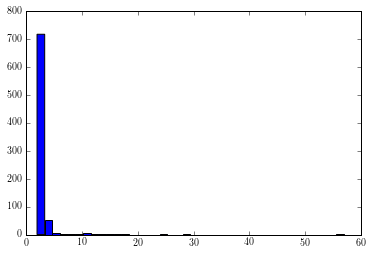

In [45]:
#The value of the constant doesn't seem to be particularly useful to look at in isolation, since many of the
#provinces in fact prefer the W+c model. So we want to calculate the integral of the foi up to age 10 (?).
nspace = 5000
x = np.linspace(1,10*12,nspace)
foi = np.zeros(nspace)
l = len(samples[:,0])-1
nplot = 800
foiInt = np.zeros(nplot)

for k in range(nplot):
    integrand = 0.
    index = np.random.randint(l)
    
    if prov in cModel:
        va = conly[index,0]
        vb = conly[index,1]
        vh = conly[index,2]
        fa = conly[index,3]
        fb = conly[index,4]
        fh = conly[index,5]
        ve = conly[index,6]
        c = conly[index,7]
        alpha = 0.
    
    if prov in wcModel:
        va = wplusc[index,0]
        vb = wplusc[index,1]
        vh = wplusc[index,2]
        fa = wplusc[index,3]
        fb = wplusc[index,4]
        fh = wplusc[index,5]
        ve = wplusc[index,6]
    
        c = wplusc[index,7]
        alpha = wplusc[index,8]
    
    j = 0
    for i in x:
        a = float(i)
        foi[j] = alpha*fh*(a/fb)**(fa-1.)*np.exp(-(a/fb)**(fa))+c
        j += 1
    
    integrand = np.sum(foi)*(x[1]-x[0])
    foiInt[k] = integrand
a,b,c = plt.hist(foiInt,bins=40)
print prov, np.median(foiInt), np.sqrt(np.var(foiInt))
print np.percentile(foiInt,[25,50,75])

In [46]:
foiIntegrated = [['KASAIOCC',3.102,3.335],['KATANGA',31.41,11.52],['KINSHASA',32.6,16.36],['EQUATEUR',2.32,0.19],\
                ['MANIEMA',3.27,0.296],['BANDUNDU',12.84,8.27],['ORIENTALE',19.66,9.32],['BASCONGO',0.98,0.22],\
                ['KASAIOR',60.1,54.02],['NKIVU',12.2,3.45],['SKIVU',18.15,6.31]]

In [47]:
outfile = open('foiIntegrated.txt','w')
for elem in foiIntegrated:
    print elem
    outfile.write(str(elem) +"\n")

['KASAIOCC', 3.102, 3.335]
['KATANGA', 31.41, 11.52]
['KINSHASA', 32.6, 16.36]
['EQUATEUR', 2.32, 0.19]
['MANIEMA', 3.27, 0.296]
['BANDUNDU', 12.84, 8.27]
['ORIENTALE', 19.66, 9.32]
['BASCONGO', 0.98, 0.22]
['KASAIOR', 60.1, 54.02]
['NKIVU', 12.2, 3.45]
['SKIVU', 18.15, 6.31]


In [48]:
foiInt = np.array(foiIntegrated)
print np.shape(foiIntegrated)

(11, 3)


In [49]:
foiMean = foiInt[:,1].astype(float)
foiSig = foiInt[:,2].astype(float)
xplot = np.linspace(0,10,11)

<Container object of 3 artists>

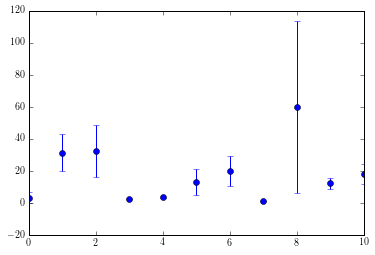

In [50]:
plt.errorbar(xplot,foiMean,yerr=foiSig,fmt='o')

In [51]:
foiIntegrated

[['KASAIOCC', 3.102, 3.335],
 ['KATANGA', 31.41, 11.52],
 ['KINSHASA', 32.6, 16.36],
 ['EQUATEUR', 2.32, 0.19],
 ['MANIEMA', 3.27, 0.296],
 ['BANDUNDU', 12.84, 8.27],
 ['ORIENTALE', 19.66, 9.32],
 ['BASCONGO', 0.98, 0.22],
 ['KASAIOR', 60.1, 54.02],
 ['NKIVU', 12.2, 3.45],
 ['SKIVU', 18.15, 6.31]]